# Chapter 12: Matrix Acidizing Design
**Objective:** Calculate the Maximum Surface Injection Pressure ($P_{max}$) to stimulate the well without fracturing the formation.

**Author:** Ade Anggi Naluriawan Santoso

**The Concept:**
Acids (HCl for carbonates, HF-HCl for sandstones) are injected to dissolve minerals clogging the pore throats near the wellbore.

**The Golden Rule:**
$$P_{bottomhole} < P_{fracture}$$

If we exceed the fracture pressure, the acid will shoot down a single crack, bypassing the damaged zone we are trying to clean. This wastes the treatment.

**The Equation:**
To control this from the surface, we calculate:
$$P_{surf\_max} = (G_{frac} \cdot D) - P_{hydro} + \Delta P_{friction} - Safety$$

Where:
* $G_{frac}$: Fracture Gradient of the rock (psi/ft).
* $P_{hydro}$: Hydrostatic weight of the acid column.
* $\Delta P_{friction}$: Friction pressure loss in the tubing (helps us! It opposes the surface pump).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Fluid Properties & Gradients
Acid is heavier than water.
* **15% HCl:** Specific Gravity $\approx$ 1.07 (Gradient $\approx$ 0.463 psi/ft).
* **28% HCl:** Specific Gravity $\approx$ 1.14 (Gradient $\approx$ 0.494 psi/ft).

We need to calculate the bottomhole fracture pressure and the hydrostatic head of our acid.

In [2]:
def calc_pressure_limits(depth, frac_gradient, acid_sg, safety_margin=200):
    """
    Calculates the pressure limits at the bottom of the hole.
    """
    # 1. Fracture Pressure (The Ceiling)
    p_frac = frac_gradient * depth
    
    # 2. Hydrostatic Pressure of Acid (The Head Start)
    # Grad = 0.433 * SG
    grad_acid = 0.433 * acid_sg
    p_hydro = depth * grad_acid
    
    return p_frac, p_hydro, grad_acid

# --- EXAMPLE SCENARIO ---
depth_target = 9000      # ft
frac_grad = 0.75         # psi/ft (Typical hard rock)
acid_sg = 1.07           # 15% HCl
safety = 200             # psi

p_frac, p_hydro, g_acid = calc_pressure_limits(depth_target, frac_grad, acid_sg)

print(f"Bottomhole Fracture Pressure: {p_frac:.0f} psi")
print(f"Hydrostatic Pressure (Acid):  {p_hydro:.0f} psi")

Bottomhole Fracture Pressure: 6750 psi
Hydrostatic Pressure (Acid):  4170 psi


## 2. Friction Pressure (The Dynamic Variable)
The faster we pump, the more friction we generate in the tubing (usually Coiled Tubing is used for acid jobs).

**Counter-Intuitive Physics:**
Friction acts *against* the flow.
* If we pump down Coiled Tubing, the Surface Pump must overcome (Bottom Pressure - Hydrostatic + **Friction**).
* Therefore, **Higher Friction allows us to use Higher Surface Pressure** while keeping the bottomhole pressure the same.

$$P_{surf} = P_{bottom} - P_{hydro} + P_{friction}$$

If we set $P_{bottom} = P_{frac}$:
$$P_{max\_surf} = P_{frac} - P_{hydro} + P_{friction} - Safety$$

In [3]:
def calc_coiled_tubing_friction(rate_bpm, ct_id_in, length_ft, visc_cp=1.0):
    """
    Calculates friction pressure loss (psi) in Coiled Tubing.
    Using simplified correlation (proportional to q^2).
    """
    # This is a placeholder for a complex friction model
    # Rate in bbl/min (bpm)
    
    if rate_bpm <= 0: return 0.0
    
    # Approx Friction Factor for 1.5" CT ~ 200 psi/1000ft at 1 bpm (very high due to small ID)
    # Using a generic coefficient for demonstration
    # dP = C * Q^2 * L
    
    coeff = 50 # Tuning parameter for specific CT size
    
    # Smaller ID = Massive Friction increase (1/d^5)
    d_factor = (1.5 / ct_id_in) ** 5 
    
    friction_psi = coeff * (rate_bpm**2) * (length_ft / 1000) * d_factor
    
    return friction_psi

# Test Friction at 1 BPM in 1.5" CT
f_test = calc_coiled_tubing_friction(1.0, 1.5, depth_target)
print(f"Friction at 1 BPM: {f_test:.0f} psi")

Friction at 1 BPM: 450 psi


## 3. The Safe Operating Window (P-Rate Plot)
We now generate the "Job Design Plot". This tells the pump operator on site:
*"If you pump at 2 bpm, do not exceed 3000 psi on the gauge."*

We plot **Max Surface Pressure** vs. **Injection Rate**.

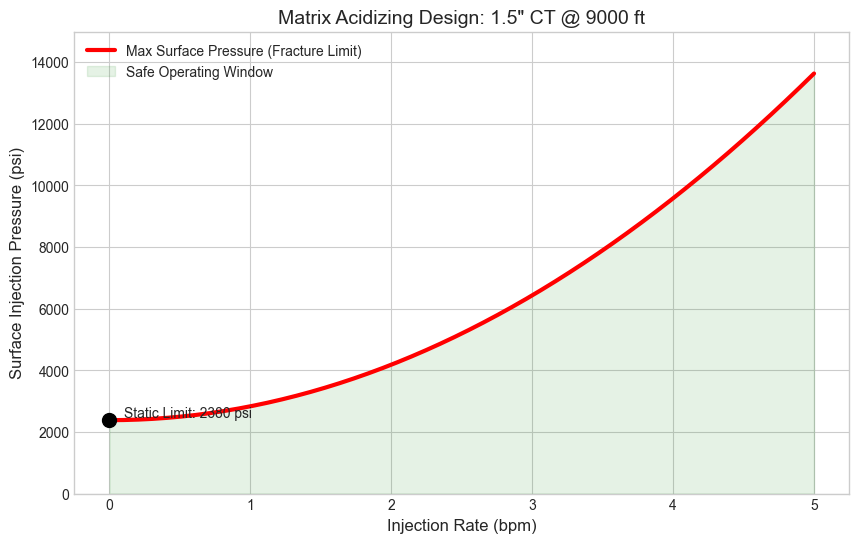

In [4]:
rates = np.linspace(0, 5, 50) # 0 to 5 BPM

p_max_surface = []
friction_values = []

for q in rates:
    # Calculate Friction for this rate
    dp_fric = calc_coiled_tubing_friction(q, 1.5, depth_target) # 1.5" CT
    
    # Calculate Max Surface Pressure
    # P_surf_max = P_frac - P_hydro + Friction - Safety
    p_surf = p_frac - p_hydro + dp_fric - safety
    
    p_max_surface.append(p_surf)
    friction_values.append(dp_fric)

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# 1. The Limit Line
plt.plot(rates, p_max_surface, 'r-', linewidth=3, label='Max Surface Pressure (Fracture Limit)')

# 2. Safe Zone
plt.fill_between(rates, 0, p_max_surface, color='green', alpha=0.1, label='Safe Operating Window')

# 3. Add Static Limit Reference (Rate = 0)
static_limit = p_frac - p_hydro - safety
plt.scatter(0, static_limit, color='black', s=100, zorder=10)
plt.text(0.1, static_limit, f"Static Limit: {static_limit:.0f} psi", verticalalignment='bottom')

plt.title(f"Matrix Acidizing Design: 1.5\" CT @ {depth_target} ft", fontsize=14)
plt.xlabel("Injection Rate (bpm)", fontsize=12)
plt.ylabel("Surface Injection Pressure (psi)", fontsize=12)
plt.ylim(0, max(p_max_surface)*1.1)
plt.legend()
plt.grid(True)

plt.show()

## Summary
This chart is vital for the execution of the job.

**Interpretation:**
* Notice the curve goes **UP**?
* As rate increases, friction increases. Since friction fights the pump but *protects* the formation (by taking pressure drop), we can actually show **higher** gauge pressure at higher rates without fracturing the rock.
* **Caution:** If you stop pumping suddenly (Rate $\to$ 0), friction disappears. The bottomhole pressure might spike if the pumps don't bleed off instantly.

**Next Step:**
We proceed to the final chapter, **Hydraulic Fracturing**, where we intentionally *break* this limit.